In [24]:
import os
import pickle
import torch
import pandas as pd

from tqdm import tqdm
from sklearn.metrics import f1_score
from collections import Counter

text_counter = Counter()
tqdm.pandas()
mps_device = torch.device("mps")
torch.cuda.empty_cache()

In [25]:
WEIGHTS_PATH = './../weights/'
DATASET_PATH = './../data/processed/processed_data.csv'
INTERMEDIATE_PATH = './../intermediate/'
RESULTS_PATH = './../results/'
VALIDATION = './../data/Validation.txt'


embedding_size = 512
no_of_rows     = None
window_size    = 4
max_epochs     = 10
learning_rate  = 0.001
reg_lambda     = 1
batch_size     = 4096
train_split    = 0.8
is_train       = True
new_weights    = True
use_biases     = False
problem        = 'skipgram'

epochs_stat = []

In [26]:
class Net(object):
    
    def __init__(self):
        self.y_pred = None
        self.emb    = None

        if(os.path.exists(WEIGHTS_PATH + 'skipgram_weights_' + str(vocab_size) + '.pt') and (new_weights == False)):
            self.weights = torch.load(WEIGHTS_PATH + 'skipgram_weights_' + str(vocab_size) + '.pt')
            self.biases = torch.load(WEIGHTS_PATH + 'skipgram_biases_' + str(vocab_size) + '.pt')
        else:
            self.weights = []
            self.biases  = []
            
            self.weights.append(torch.rand((vocab_size, embedding_size), device=mps_device) * 2 - 1)
            self.weights.append(torch.rand((embedding_size, vocab_size), device=mps_device) * 2 - 1)
            if(use_biases):
                self.biases.append(torch.rand((embedding_size), device=mps_device) * 2 - 1)
                self.biases.append(torch.rand((vocab_size), device=mps_device) * 2 - 1)
            else:
                self.biases.append(torch.zeros((embedding_size), device=mps_device))
                self.biases.append(torch.zeros((vocab_size), device=mps_device))

    def __call__(self, X):
        self.emb = (torch.matmul(X,self.weights[0]) + self.biases[0])
        self.y_pred = torch.softmax(torch.matmul(self.emb, self.weights[1]) + self.biases[1], dim=1)
        return self.y_pred

    def backward(self, X, y, lamda):
        
        del_W = []
        del_b = []

        delta = self.y_pred - y
        del_b.insert(0,torch.sum(delta, axis = 0, keepdims = True))
        del_W.insert(0,torch.matmul(self.emb.T, delta) + lamda * (self.weights[1]))

        delta = torch.matmul(delta, self.weights[1].T) * (self.emb)
        del_b.insert(0,torch.sum(delta, axis = 0, keepdims = True))
        del_W.insert(0,torch.matmul(X.T, delta) + lamda * (self.weights[0]))
        return del_W, del_b

    
class Optimizer(object):
    '''
    '''
    def __init__(self, learning_rate, weights, biases, optimizer="gradient"):
        
        
        self.optimizer = optimizer
        
        self.m_dw = [torch.zeros((w.shape), device=mps_device) for w in weights]
        self.m_db = [torch.zeros((b.shape), device=mps_device) for b in biases]
        self.v_dw = [torch.zeros((w.shape), device=mps_device) for w in weights]
        self.v_db = [torch.zeros((b.shape), device=mps_device) for b in biases]
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.eta = learning_rate
        self.t = 0

    def step(self, weights, biases, delta_weights, delta_biases):
        
        if(self.optimizer == "gradient"):
            return self.gradient(weights, biases, delta_weights, delta_biases)
        elif(self.optimizer == "adam"):
            return self.adam(weights, biases, delta_weights, delta_biases)
    
    def adam(self, weights, biases, delta_weights, delta_biases):
        self.t += 1

        self.m_dw = [self.beta1 * m + (1 - self.beta1) * del_w for m, del_w in zip(self.m_dw, delta_weights)]
        self.m_db = [self.beta1 * m + (1 - self.beta1) * del_b for m, del_b in zip(self.m_db, delta_biases)]
        self.v_dw = [self.beta2 * v + (1 - self.beta2) * (del_w**2) for v, del_w in zip(self.v_dw, delta_weights)]
        self.v_db = [self.beta2 * v + (1 - self.beta2) * (del_b**2) for v, del_b in zip(self.v_db, delta_biases)]

        # bias correction
        m_hat_dw = [m / (1 - self.beta1 ** self.t) for m in self.m_dw]
        v_hat_dw = [v / (1 - self.beta2 ** self.t) for v in self.v_dw]

        m_hat_db = [m / (1 - self.beta1 ** self.t) for m in self.m_db]
        v_hat_db = [v / (1 - self.beta2 ** self.t) for v in self.v_db]

        # update weights and biases
        weights = [w - self.eta * m_hat / ((torch.sqrt(v_hat) + self.epsilon)) for w, m_hat, v_hat in zip(weights, m_hat_dw, v_hat_dw)] 
        biases = [b - self.eta * m_hat / ((torch.sqrt(v_hat) + self.epsilon)) for b, m_hat, v_hat in zip(biases, m_hat_db, v_hat_db)]
        return weights, biases

    
    def gradient(self, weights, biases, delta_weights, delta_biases):
        for i in range(len(weights)):
            weights[i] = weights[i] - self.eta*delta_weights[i]
            biases[i] = biases[i] - self.eta*delta_biases[i]
        return weights, biases

In [27]:
def get_embeddings(word):
    try:
        val = word2idx[word]
        input_arr = torch.zeros((vocab_size), dtype=torch.float, device=mps_device)
        input_arr[val] = 1
        emb = torch.matmul(input_arr,net.weights[0]) + net.biases[0]
        return emb
    except:
        return torch.empty(0, dtype=torch.float, device=mps_device)

def get_result(word1, word2, word3, problem='skipgram', window=4):
    w1_emb = get_embeddings(word1)
    w2_emb = get_embeddings(word2)    
    w3_emb = get_embeddings(word3)    
    if((torch.numel(w1_emb) != 0) and (torch.numel(w2_emb) != 0) and (torch.numel(w3_emb) != 0)):
        w4_emb = w1_emb + w3_emb - w2_emb
        output = torch.softmax(torch.matmul(w4_emb, net.weights[1]) + net.biases[1], dim=1)
        if(problem=='skipgram'):
            topk_preds = torch.topk(output, k=window).indices.tolist()
            ans = [idx2word[x] for x in topk_preds[0]]
        else:
            ans = idx2word[torch.argmax(output).item()]
        return ans
    return "UNK"


def get_embeddings(word):
    try:
        val = word2idx[word]
        input_arr = torch.zeros((vocab_size), dtype=torch.float, device=mps_device)
        input_arr[val] = 1
        emb = torch.matmul(input_arr,net.weights[0]) + net.biases[0]
        return emb
    except:
        return torch.empty(0, dtype=torch.float, device=mps_device)
    
def get_accuracy(validation):
    accuracy = torch.empty(0, dtype=torch.float, device=mps_device)
    for _, row in validation.iterrows():
        w1_emb = get_embeddings(row['word1'])
        w2_emb = get_embeddings(row['word2'])    
        w3_emb = get_embeddings(row['word3'])
        w4_emb = get_embeddings(row['word4'])
        
        if((torch.numel(w1_emb) != 0) and (torch.numel(w2_emb) != 0) and (torch.numel(w3_emb) != 0)):
            pred_emb = w1_emb + w3_emb - w2_emb
            accuracy = torch.cat(accuracy, cosine_similarity(pred_emb, w4_emb), dim=0)
    return torch.mean(accuracy, dim=0)

def cosine_similarity(A, B):
    C = torch.squeeze(A)
    D = torch.squeeze(B)
    return torch.dot(C, D) / (torch.norm(C) * torch.norm(D))

def cross_entropy_loss(y_pred, y_true):
    if(mps_device.type == 'mps'):
        return -torch.mean(custom_nansum(y_true * torch.log(y_pred), axis=-1))
    else:
        return -torch.mean(torch.nansum(y_true * torch.log(y_pred), axis=-1))

def get_dataset(words, window_size):
    data = pd.DataFrame(columns=["word", "context_words"])
    for index, word in enumerate(words):
        context_words = words[max(0, index - window_size): index] + words[index + 1: index + window_size + 1]
        context_words = list(set(context_words))
        data.loc[len(data.index)] = [word, context_words]
    global dataset
    dataset = pd.concat([dataset,data])
    
def custom_nansum(input_tensor, axis=None):
    # Replace NaN values with 0
    input_tensor = torch.where(torch.isnan(input_tensor), torch.tensor(0., device=input_tensor.device), input_tensor)
    
    # Compute the sum over the specified axis
    if axis is None:
        return torch.sum(input_tensor)
    else:
        return torch.sum(input_tensor, dim=axis)
    
    
def get_batch_data(start_index, end_index):

    batch_dataset = dataset[start_index:end_index].reset_index(drop=True)
    batch_size = batch_dataset.shape[0]
    batch_input = torch.zeros([batch_size, vocab_size], dtype=torch.float, device=mps_device)
    batch_output = torch.zeros([batch_size, vocab_size], dtype=torch.float, device=mps_device)

    for index, data in batch_dataset.iterrows():
        batch_input[index, data['word']] = 1
        for ind in data['context_words']:
            batch_output[index, ind] = 1
            
    return batch_input, batch_output


def train(net, optimizer, lamda, max_epochs, dev_input, dev_target, batch_size, train_size):

    stop = False
    value = 999999999
    
    for e in range(max_epochs):
        first_loss = True
        epoch = {}
        batches = []
        losses = []
        for start_index in range(0, train_size, batch_size):
            end_index = min(start_index + batch_size, train_size)
            batch_input, batch_target = get_batch_data(start_index, end_index)
            pred = net(batch_input)

            # Compute gradients of loss w.r.t. weights and biases
            dW, db = net.backward(batch_input, batch_target, lamda)

            # Get updated weights based on current weights and gradients
            weights_updated, biases_updated = optimizer.step(net.weights, net.biases, dW, db)

            # Update model's weights and biases
            net.weights = weights_updated
            net.biases = biases_updated
            loss = cross_entropy_loss(pred, batch_target)
            print(e, start_index, loss.item())
            batches.append(start_index)
            losses.append(loss.item())
            if(torch.isnan(loss) or torch.isinf(loss)):
                stop = True
                break

            if(first_loss):
                first_loss = False
                if(value<loss.item()):
                    stop = True
                    break
                else:
                    value = loss.item()

        epoch['batches'] = batches
        epoch['losses'] = losses
            

        dev_pred = net(dev_input)
        indices = torch.topk(dev_pred, k=window_size, dim=1)[1][:, -window_size:]
        converted_matrix = torch.zeros_like(dev_pred)
        converted_matrix[torch.arange(dev_pred.shape[0])[:, None], indices] = 1
        numpy_dev_target = dev_target.cpu().numpy()
        converted_matrix = converted_matrix.cpu().numpy()
        score = f1_score(numpy_dev_target, converted_matrix, average='micro')
        print('F1 Score on dev data: {:.5f}'.format(score))
        epoch['f1_score'] = score
        epochs_stat.append(epoch)
        if(stop):
            break

### Loading Data

In [20]:
df = pd.read_csv(DATASET_PATH ,nrows = no_of_rows)
df = df.dropna()

df['sentences'] = df['sentences'].apply(lambda sentence : sentence.split())
_ = df['sentences'].apply(text_counter.update)
text_counter.update(['UNK'])
vocab_size = len(text_counter)

words, _ = zip(*text_counter.most_common(vocab_size))
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for i, w in enumerate(words)}


# dataset = pd.read_pickle('dataset.pkl')
df['sentences'] = df['sentences'].apply(lambda words : [word2idx[word] for word in words])

if(no_of_rows==None and os.path.exists(INTERMEDIATE_PATH + 'dataset.pkl')):
   dataset = pd.read_pickle(INTERMEDIATE_PATH + 'dataset.pkl') 

elif(os.path.exists(INTERMEDIATE_PATH + 'dataset_'+str(no_of_rows)+'.pkl')):
    dataset = pd.read_pickle(INTERMEDIATE_PATH + 'dataset_'+str(no_of_rows)+'.pkl')
else:
    dataset = pd.DataFrame(columns=["word", "context_words"])
    _ = df['sentences'].progress_apply(lambda x : get_dataset(x, window_size))

    dataset = dataset.sample(frac=1).reset_index(drop=True)
    if(no_of_rows==None):
        dataset.to_pickle(INTERMEDIATE_PATH + 'dataset.pkl') 
    else:
        dataset.to_pickle(INTERMEDIATE_PATH + 'dataset_'+str(no_of_rows)+'.pkl')

data_size = dataset.shape[0]

print("Vocab length :", vocab_size)
print("Dataset size :", data_size)

Vocab length : 75993
Dataset size : 1275


### Training the model

In [21]:
train_size = max(int(train_split*data_size), data_size-5000)

net = Net()
optimizer = Optimizer(learning_rate, net.weights, net.biases, optimizer="adam")

In [22]:
if(is_train):
    dev_input, dev_target = get_batch_data(train_size, data_size)
    train(net, optimizer, reg_lambda, max_epochs, dev_input, dev_target, batch_size, train_size)

    torch.save(net.weights, WEIGHTS_PATH + 'skipgram_weights_' + str(vocab_size) + '.pt')
    torch.save(net.biases, WEIGHTS_PATH + 'skipgram_biases_' + str(vocab_size) + '.pt')
else:
    net.weights = torch.load(WEIGHTS_PATH + 'skipgram_weights_' + str(vocab_size) + '.pt')
    net.biases = torch.load(WEIGHTS_PATH + 'skipgram_biases_' + str(vocab_size) + '.pt')

0 0 67.99065399169922
F1 Score on dev data: 0.00000
1 0 67.4131851196289
F1 Score on dev data: 0.00000
2 0 66.8419418334961
F1 Score on dev data: 0.00000
3 0 66.27549743652344
F1 Score on dev data: 0.00000
4 0 65.71369934082031
F1 Score on dev data: 0.00000
5 0 65.15665435791016
F1 Score on dev data: 0.00000
6 0 64.6046371459961
F1 Score on dev data: 0.00000
7 0 64.057861328125
F1 Score on dev data: 0.00000
8 0 63.51643371582031
F1 Score on dev data: 0.00000
9 0 62.98044204711914
F1 Score on dev data: 0.00000


### Validation

In [23]:
validation = pd.read_csv(VALIDATION, sep=' ', names=['word1','word2','word3','word4'])

validation['word1'] = validation['word1'].apply(lambda x : x.lower())
validation['word2'] = validation['word2'].apply(lambda x : x.lower())
validation['word3'] = validation['word3'].apply(lambda x : x.lower())
validation['word4'] = validation['word4'].apply(lambda x : x.lower())

validation['pred'] = validation[['word1','word2','word3']].progress_apply(lambda x : get_result(x['word1'], x['word2'], x['word3'], problem=problem), axis = 1)
validation['found'] = validation[['word4','pred']].progress_apply(lambda x : x['word4'] in x['pred'], axis=1)

# count = len(os.listdir(RESULTS_PATH))
# validation.to_csv(RESULTS_PATH + "value_"+str(count)+'_'+str(vocab_size)+'_'+str(no_of_rows)+problem+'.csv',index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 991/991 [00:00<00:00, 166943.34it/s]


In [9]:
validation[validation['found']==True]

,word1,word2,word3,word4,pred,found


### Example

In [36]:


get_result('king','man','queen', problem='skipgram')

# get_similarity('queen', 'woman')

['pinnacle', 'students', 'kitchen', 'shmotherin']

### Plots

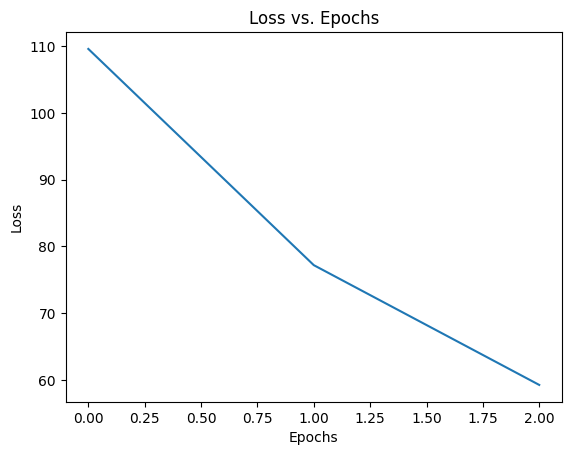

In [118]:
epochs = list(range(len(epochs_stat)))
total_loss = []
for i in range(len(epochs_stat)):
    total_loss.append(sum(epochs_stat[i]['losses'])/len(epochs_stat[i]['losses']))
    
plot_loss_vs_batch(epochs, total_loss)

ValueError: x and y must have same first dimension, but have shapes (8,) and (10,)

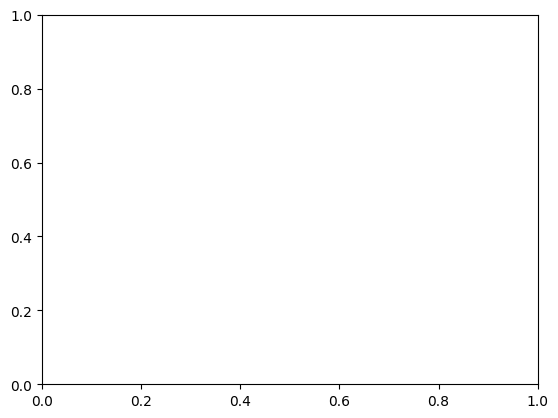

In [99]:
plot_f1_vs_epoch(epochs,x)

In [100]:
import matplotlib.pyplot as plt

def plot_f1_vs_epoch(batches, losses):
    plt.figure()
    plt.plot(batches, losses)
    plt.xlabel('Epochs')
    plt.ylabel('F1 score')
    plt.title('Fl score vs. Epochs on Dev data')
    plt.show()

In [101]:
import matplotlib.pyplot as plt

def plot_loss_vs_batch(batches, losses):
    plt.figure()
    plt.plot(batches, losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.show()

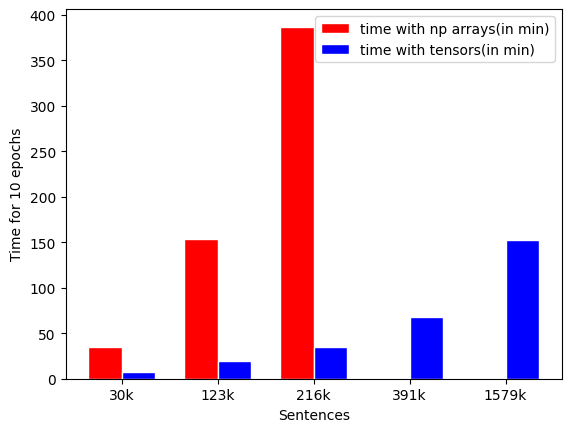

In [122]:
import matplotlib.pyplot as plt

# Define the input list
input_list = ['30k', '123k', '216k', '391k', '1579k']

# Define the two lists to compare
list1 = [35, 154, 387, 0, 0]
list2 = [7, 19, 35, 68, 152]

# Set the width of the bars
barWidth = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(input_list))
r2 = [x + barWidth for x in r1]

# Create the plot
plt.bar(r1, list1, color='red', width=barWidth, edgecolor='white', label='time with np arrays(in min)')
plt.bar(r2, list2, color='blue', width=barWidth, edgecolor='white', label='time with tensors(in min)')

# Add xticks on the middle of the group bars
plt.xlabel('Sentences')
plt.ylabel('Time for 10 epochs')
plt.xticks([r + barWidth / 2 for r in r1], input_list)

# Create a legend & show the plot
plt.legend()
plt.show()

